In [1]:
from __future__ import print_function
#%matplotlib inline
#import argparse
import os
#import random
import torch
import torch.nn as nn
import torch.nn.parallel
#import torch.backends.cudnn as cudnn
#import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
#import torchvision.utils as vutils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
#from IPython.display import HTML
from torchvision.utils import make_grid

In [2]:
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import save_image

In [3]:
path = 'data/archive/Abstract_gallery'
os.path.exists(path)

True

In [4]:
image_size = (64, 64)
dataset = datasets.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               # normalize to the range [-1, 1]
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

batch_size = 64
# create a dataloader 
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [5]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

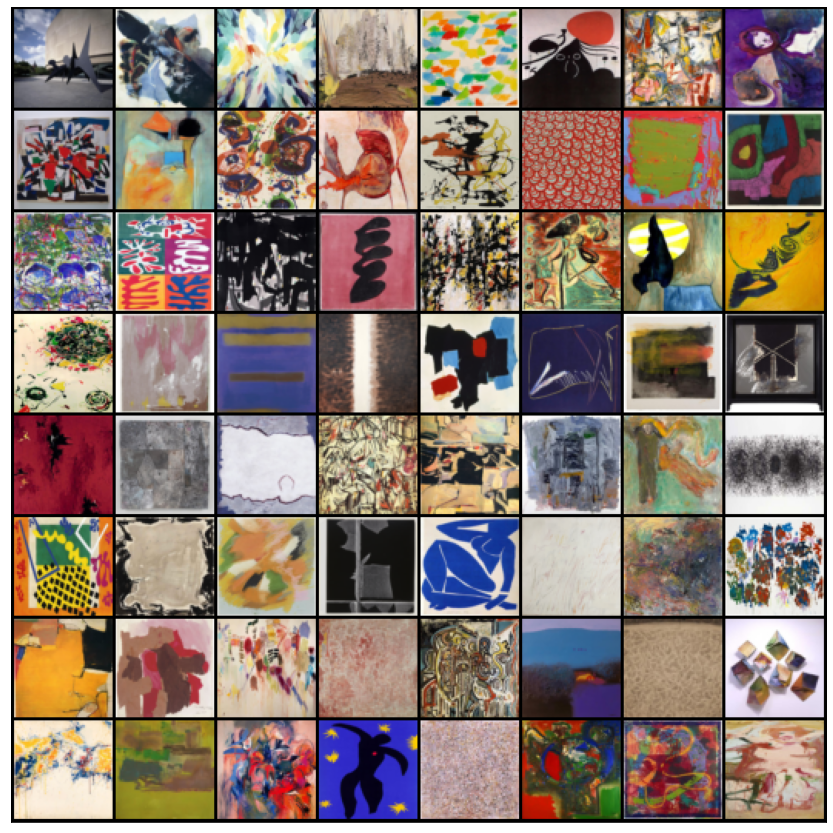

In [6]:
show_batch(dataloader)

In [7]:
n_epochs = 2
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 1
latent_dim = 100
img_size = 64
channels = 3
n_critic = 5
clip_value = 0.01
sample_interval = 3200

In [8]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [11]:
k = 2
p = 6


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

In [12]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [13]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [14]:
batches_done = 0
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done % sample_interval == 0:
                save_image(fake_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += n_critic

[Epoch 0/2] [Batch 0/44] [D loss: -0.006955] [G loss: 0.042054]
[Epoch 0/2] [Batch 5/44] [D loss: -6.383328] [G loss: 0.075924]
[Epoch 0/2] [Batch 10/44] [D loss: -21.723707] [G loss: -0.031746]
[Epoch 0/2] [Batch 15/44] [D loss: -30.581123] [G loss: -0.381399]
[Epoch 0/2] [Batch 20/44] [D loss: -33.672611] [G loss: -0.802133]
[Epoch 0/2] [Batch 25/44] [D loss: -37.188847] [G loss: -1.302307]
[Epoch 0/2] [Batch 30/44] [D loss: -39.118988] [G loss: -1.787526]
[Epoch 0/2] [Batch 35/44] [D loss: -36.523521] [G loss: -2.353113]
[Epoch 0/2] [Batch 40/44] [D loss: -33.753773] [G loss: -2.589120]
[Epoch 1/2] [Batch 0/44] [D loss: -37.819740] [G loss: -3.656590]
[Epoch 1/2] [Batch 5/44] [D loss: -33.840450] [G loss: -4.203932]
[Epoch 1/2] [Batch 10/44] [D loss: -36.519222] [G loss: -4.590320]
[Epoch 1/2] [Batch 15/44] [D loss: -33.459839] [G loss: -5.271420]
[Epoch 1/2] [Batch 20/44] [D loss: -33.748180] [G loss: -5.912607]
[Epoch 1/2] [Batch 25/44] [D loss: -37.955238] [G loss: -5.979878]
[Ep